In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error ,mean_absolute_error
from math import  sqrt
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")
import statistics as st
from scipy.stats import mode, skew, kurtosis
import seaborn as sns

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dense, SimpleRNN
from keras.layers import LSTM
from keras.layers import Dropout


import pandas as pd
import joblib
import matplotlib.pyplot as plt
import math

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

from keras.models import Sequential
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import SimpleRNN, Embedding
from tensorflow.keras.preprocessing import sequence

from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import skew, kurtosis

import warnings
warnings.filterwarnings("ignore")

###Read data

In [93]:
eth_df = pd.read_csv("/content/Ethereum Historical Data (1).csv")
eth_df

,Date,Price,Open,High,Low,Vol.,Change %
0,06/01/2024,"3,815.95","3,762.63","3,832.35","3,753.32",143.81K,1.42%
1,05/31/2024,"3,762.66","3,747.89","3,844.96","3,724.57",294.56K,0.40%
2,05/30/2024,"3,747.55","3,767.22","3,824.94","3,703.74",293.81K,-0.58%
3,05/29/2024,"3,769.57","3,845.56","3,886.44","3,745.72",353.25K,-1.98%
4,05/28/2024,"3,845.56","3,894.33","3,929.21","3,775.08",436.24K,-1.25%
...,...,...,...,...,...,...,...
1915,03/05/2019,136.82,125.97,141.11,125.44,16.74M,8.61%
1916,03/04/2019,125.97,131.02,131.57,123.25,14.11M,-3.85%
1917,03/03/2019,131.01,132.77,168.42,129.05,10.64M,-1.32%
1918,03/02/2019,132.76,135.72,136.36,130.74,11.29M,-2.18%


###Data processing

In [94]:
eth_df['Date'] = pd.to_datetime(eth_df['Date'])
eth_df.reset_index(drop=True)
eth_df.set_index('Date', inplace=True)

In [95]:
eth_df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2024-06-01,"3,815.95","3,762.63","3,832.35","3,753.32",143.81K,1.42%
2024-05-31,"3,762.66","3,747.89","3,844.96","3,724.57",294.56K,0.40%
2024-05-30,"3,747.55","3,767.22","3,824.94","3,703.74",293.81K,-0.58%
2024-05-29,"3,769.57","3,845.56","3,886.44","3,745.72",353.25K,-1.98%
2024-05-28,"3,845.56","3,894.33","3,929.21","3,775.08",436.24K,-1.25%
...,...,...,...,...,...,...
2019-03-05,136.82,125.97,141.11,125.44,16.74M,8.61%
2019-03-04,125.97,131.02,131.57,123.25,14.11M,-3.85%
2019-03-03,131.01,132.77,168.42,129.05,10.64M,-1.32%


In [96]:
print(eth_df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1920 entries, 2024-06-01 to 2019-03-01
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Price     1920 non-null   object
 1   Open      1920 non-null   object
 2   High      1920 non-null   object
 3   Low       1920 non-null   object
 4   Vol.      1920 non-null   object
 5   Change %  1920 non-null   object
dtypes: object(6)
memory usage: 105.0+ KB
None


In [97]:
# Hàm để chuyển đổi giá trị có 'K', 'M', hoặc 'B' thành số thực.
def convert_volume(value):
    if 'K' in value:
        return float(value.replace('K', '')) * 1e3
    elif 'M' in value:
        return float(value.replace('M', '')) * 1e6
    elif 'B' in value:
        return float(value.replace('B', '')) * 1e9
    else:
        return float(value)

# Áp dụng hàm cho mỗi giá trị trong cột 'Vol.'.
eth_df['Vol.'] = eth_df['Vol.'].apply(convert_volume)


In [98]:
# Hàm để chuyển đổi giá trị có dấu % thành số thực.
def convert_percent_to_float(value):
    return float(value.replace('%', '')) / 100

# Giả sử etr_df là DataFrame của bạn với cột 'Percentage' cần được chuyển đổi.
# etr_df['Percentage'] = ...

# Áp dụng hàm cho mỗi giá trị trong cột 'Percentage'.
eth_df['Change %'] = eth_df['Change %'].apply(convert_percent_to_float)


In [99]:
eth_df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2024-06-01,"3,815.95","3,762.63","3,832.35","3,753.32",143810.0,0.0142
2024-05-31,"3,762.66","3,747.89","3,844.96","3,724.57",294560.0,0.0040
2024-05-30,"3,747.55","3,767.22","3,824.94","3,703.74",293810.0,-0.0058
2024-05-29,"3,769.57","3,845.56","3,886.44","3,745.72",353250.0,-0.0198
2024-05-28,"3,845.56","3,894.33","3,929.21","3,775.08",436240.0,-0.0125
...,...,...,...,...,...,...
2019-03-05,136.82,125.97,141.11,125.44,16740000.0,0.0861
2019-03-04,125.97,131.02,131.57,123.25,14110000.0,-0.0385
2019-03-03,131.01,132.77,168.42,129.05,10640000.0,-0.0132


###Descriptive Analysis

In [100]:
eth_df.describe()


,Vol.,Change %
count,1.920000e+03,1920.000000
mean,1.454516e+07,0.002749
std,1.122081e+08,0.044474
min,2.703000e+04,-0.445500
25%,4.808800e+05,-0.017600
50%,1.165000e+06,0.001400
75%,8.500000e+06,0.022925
max,1.790000e+09,0.259600


In [101]:
eth_df['Price'] = eth_df['Price'].str.replace(',', '').astype(float)
eth_df['Open'] = eth_df['Open'].str.replace(',', '').astype(float)
eth_df['High'] =eth_df['High'].str.replace(',', '').astype(float)
eth_df['Low'] = eth_df['Low'].str.replace(',', '').astype(float)
eth_df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2024-06-01,3815.95,3762.63,3832.35,3753.32,143810.0,0.0142
2024-05-31,3762.66,3747.89,3844.96,3724.57,294560.0,0.0040
2024-05-30,3747.55,3767.22,3824.94,3703.74,293810.0,-0.0058
2024-05-29,3769.57,3845.56,3886.44,3745.72,353250.0,-0.0198
2024-05-28,3845.56,3894.33,3929.21,3775.08,436240.0,-0.0125
...,...,...,...,...,...,...
2019-03-05,136.82,125.97,141.11,125.44,16740000.0,0.0861
2019-03-04,125.97,131.02,131.57,123.25,14110000.0,-0.0385
2019-03-03,131.01,132.77,168.42,129.05,10640000.0,-0.0132


In [102]:
eth_description = eth_df.describe()
eth_description

,Price,Open,High,Low,Vol.,Change %
count,1920.000000,1920.000000,1920.000000,1920.000000,1.920000e+03,1920.000000
mean,1580.443599,1578.543557,1623.758177,1529.572755,1.454516e+07,0.002749
std,1205.861719,1205.229006,1239.788033,1166.097930,1.122081e+08,0.044474
min,107.900000,107.870000,117.910000,88.500000,2.703000e+04,-0.445500
25%,268.945000,268.717500,278.095000,262.277500,4.808800e+05,-0.017600
50%,1622.465000,1620.975000,1654.210000,1569.740000,1.165000e+06,0.001400
75%,2334.242500,2331.202500,2393.075000,2255.137500,8.500000e+06,0.022925
max,4808.380000,4808.340000,4864.060000,4715.430000,1.790000e+09,0.259600


In [103]:
print("Meadian \t")
eth_df.median()

Meadian 	


Price       1.622465e+03
Open        1.620975e+03
High        1.654210e+03
Low         1.569740e+03
Vol.        1.165000e+06
Change %    1.400000e-03
dtype: float64

In [104]:
print('Kurtosis\t')
eth_df.kurtosis()

Kurtosis	


Price        -0.726134
Open         -0.723653
High         -0.733476
Low          -0.729421
Vol.        156.849436
Change %      9.160245
dtype: float64

In [105]:
print('Skewness\t')
eth_df.skew()

Skewness	


Price        0.460779
Open         0.461996
High         0.462121
Low          0.454362
Vol.        12.308683
Change %    -0.341816
dtype: float64

In [106]:
# Tính toán các giá trị thống kê cột price
variance_price = st.variance(eth_df["Price"])
std_dev_price = st.stdev(eth_df["Price"])
skewness_price = skew(eth_df["Price"])
kurtosis_price = kurtosis(eth_df["Price"])
mode_price = mode(eth_df["Price"])

print("Variance:", variance_price)
print("Standard Deviation:", std_dev_price)
print("Skewness:", skewness_price)
print("Kurtosis:", kurtosis_price)
print("Mode:", mode_price)

Variance: 1454102.4859859464
Standard Deviation: 1205.861719263841
Skewness: 0.4604188994029928
Kurtosis: -0.7273679966545292
Mode: ModeResult(mode=125.24, count=2)


In [107]:
import statistics as st
from scipy.stats import skew, kurtosis

# Assuming eth_df is your DataFrame and "Price" is the column of interest.

# Calculate variance
variance_price = st.variance(eth_df["Price"])

# Calculate standard deviation
std_dev_price = st.stdev(eth_df["Price"])

# Calculate skewness
skewness_price = skew(eth_df["Price"])

# Calculate kurtosis
kurtosis_price = kurtosis(eth_df["Price"])

# Calculate mode
# Since mode might not be unique, we handle multiple modes using statistics.multimode
mode_price = st.multimode(eth_df["Price"])

print("Variance:", variance_price)
print("Standard Deviation:", std_dev_price)
print("Skewness:", skewness_price)
print("Kurtosis:", kurtosis_price)
print("Mode:", mode_price if mode_price else "No unique mode")


Variance: 1454102.4859859464
Standard Deviation: 1205.861719263841
Skewness: 0.4604188994029928
Kurtosis: -0.7273679966545292
Mode: [2083.09, 1647.05, 1323.41, 1818.07, 2229.53, 591.09, 241.26, 225.63, 206.62, 212.0, 196.14, 173.0, 125.24, 164.36, 137.92, 148.89, 181.11, 179.87, 163.47, 135.72]


In [108]:
eth_df['Price'].describe()

count    1920.000000
mean     1580.443599
std      1205.861719
min       107.900000
25%       268.945000
50%      1622.465000
75%      2334.242500
max      4808.380000
Name: Price, dtype: float64

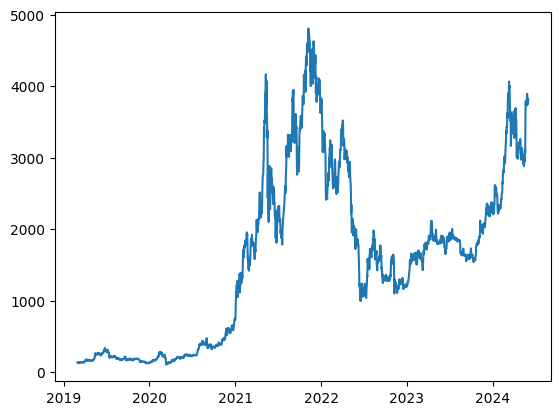

In [109]:
#df['Price'].plot(figsize=(10,5),color='red')

plt.plot(eth_df['Price'])

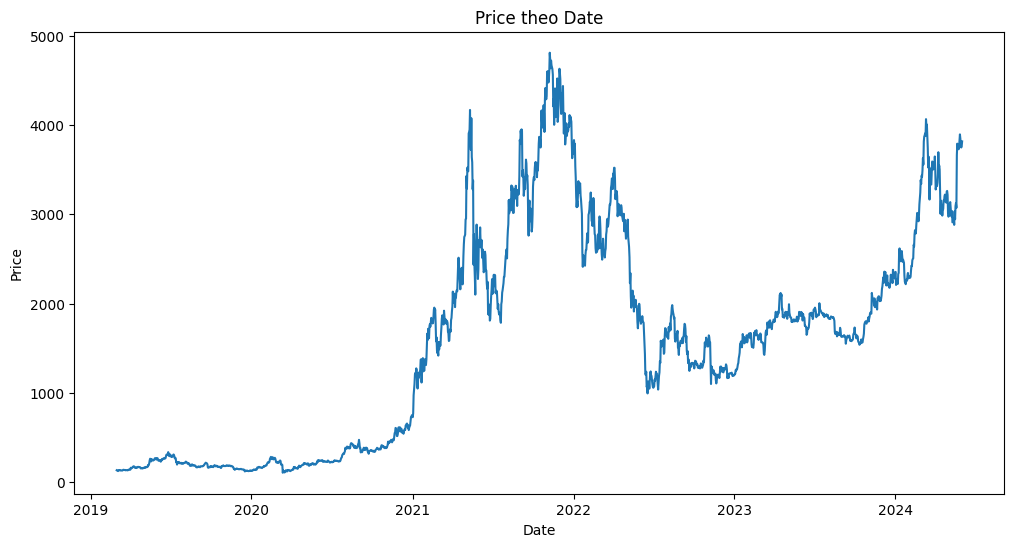

In [110]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Price', data=eth_df)

plt.title('Price theo Date')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

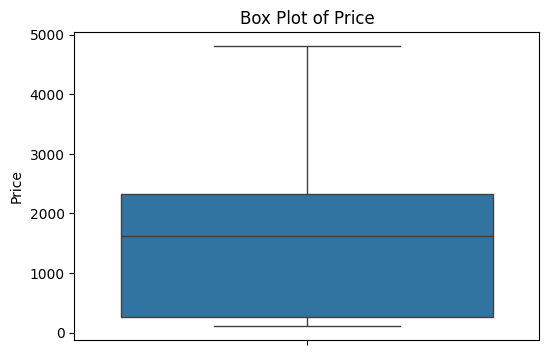

In [111]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=eth_df, y='Price')
plt.title('Box Plot of Price')
plt.ylabel('Price')
plt.show()

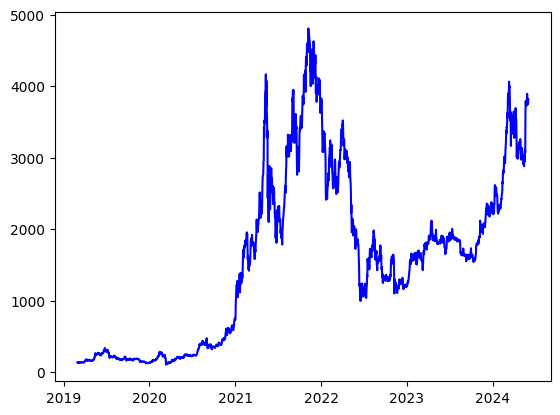

In [112]:
plt.figure()
plt.plot(eth_df["Price"], color='blue')
plt.show()

<Axes: >

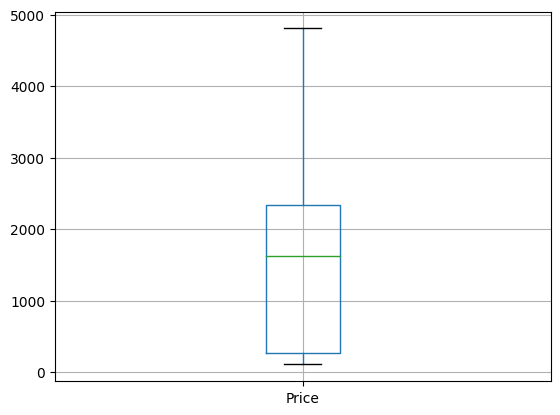

In [113]:
eth_df.boxplot(column=['Price'])

<Axes: >

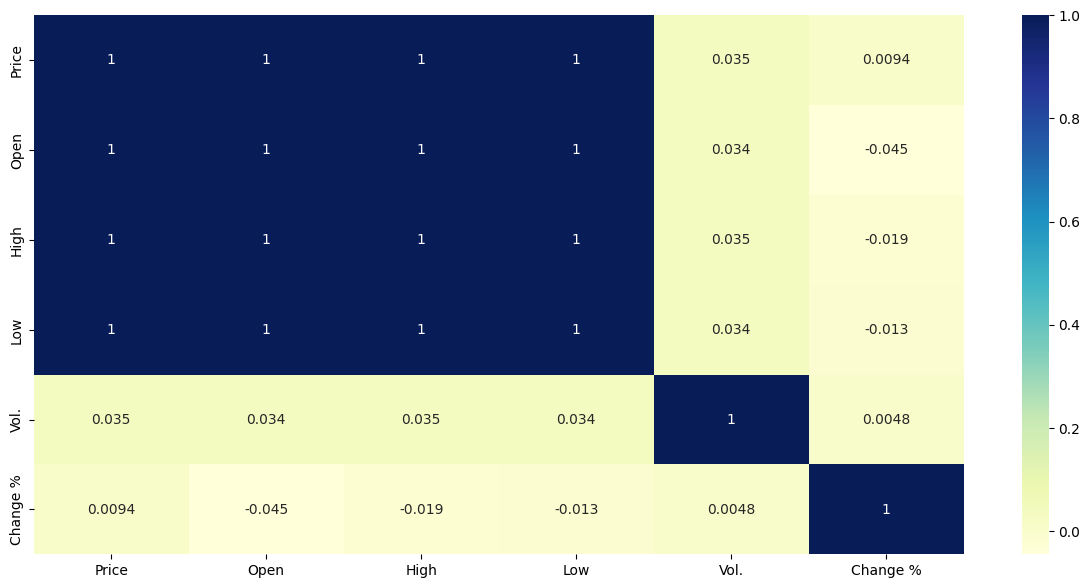

In [114]:
plt.figure(figsize=(15,7))
sns.heatmap(eth_df.corr(),annot =True,cmap="YlGnBu")

### Preprocess data ###

In [115]:

eth_df['Year'] = eth_df.index.year
eth_df['Month'] = eth_df.index.month
eth_df['Day'] = eth_df.index.day

In [116]:
eth_df


,Price,Open,High,Low,Vol.,Change %,Year,Month,Day
Date,,,,,,,,,
2024-06-01,3815.95,3762.63,3832.35,3753.32,143810.0,0.0142,2024,6,1
2024-05-31,3762.66,3747.89,3844.96,3724.57,294560.0,0.0040,2024,5,31
2024-05-30,3747.55,3767.22,3824.94,3703.74,293810.0,-0.0058,2024,5,30
2024-05-29,3769.57,3845.56,3886.44,3745.72,353250.0,-0.0198,2024,5,29
2024-05-28,3845.56,3894.33,3929.21,3775.08,436240.0,-0.0125,2024,5,28
...,...,...,...,...,...,...,...,...,...
2019-03-05,136.82,125.97,141.11,125.44,16740000.0,0.0861,2019,3,5
2019-03-04,125.97,131.02,131.57,123.25,14110000.0,-0.0385,2019,3,4
2019-03-03,131.01,132.77,168.42,129.05,10640000.0,-0.0132,2019,3,3


In [117]:
eth_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1920 entries, 2024-06-01 to 2019-03-01
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     1920 non-null   float64
 1   Open      1920 non-null   float64
 2   High      1920 non-null   float64
 3   Low       1920 non-null   float64
 4   Vol.      1920 non-null   float64
 5   Change %  1920 non-null   float64
 6   Year      1920 non-null   int32  
 7   Month     1920 non-null   int32  
 8   Day       1920 non-null   int32  
dtypes: float64(6), int32(3)
memory usage: 127.5 KB


In [118]:
eth_df.shape

(1920, 9)

**Split data**

In [119]:
df_train = eth_df[eth_df.index<='3/1/2024']
df_test = eth_df[eth_df.index>'3/1/2024']

In [120]:
print('df_train.shape: ',df_train.shape)
print('df_trest.shape: ',df_test.shape)

df_train.shape:  (1828, 9)
df_trest.shape:  (92, 9)


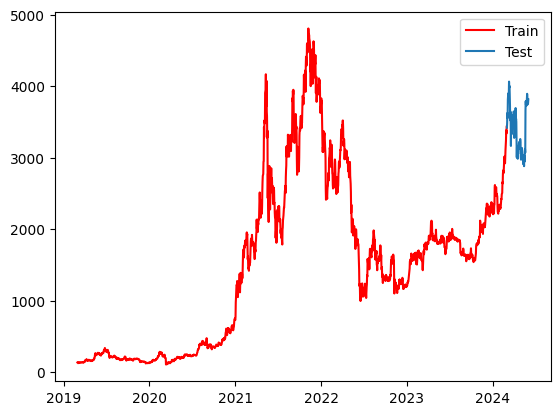

In [121]:
plt.figure()
plt.plot(pd.DataFrame(df_train).index.to_list(), pd.DataFrame(df_train['Price']), color='red', label='Train')
plt.plot(pd.DataFrame(df_test).index.to_list(),pd.DataFrame(df_test['Price']), label ='Test')
plt.legend()
plt.show()

In [122]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_train_scaled = scaler.fit_transform(df_train)
df_test_scaled = scaler.transform(df_test)

df_train_scaled = pd.DataFrame(df_train_scaled, index=df_train.index, columns=df_train.columns)
df_test_scaled = pd.DataFrame(df_test_scaled, index=df_test.index, columns=df_test.columns)

In [123]:
X_train_flat = df_train_scaled.drop(columns=['Price'])
y_train_flat = df_train_scaled['Price']
X_test_flat = df_test_scaled.drop(columns=['Price'])
y_test_flat = df_test_scaled['Price']

In [124]:
X_train_flat = df_train_scaled.drop(columns=['Price'])
y_train_flat = df_train_scaled['Price']
X_test_flat = df_test_scaled.drop(columns=['Price'])
y_test_flat = df_test_scaled['Price']

In [125]:
def train_test_split(X_train, y_train,X_test,y_test,test_size, window_size=10):
    if window_size is not None:
        X_train = np.array([X_train[i:i+window_size] for i in range(len(X_train)-window_size)])
        y_train = y_train[window_size:]
        X_test = np.array([X_test[i:i+window_size] for i in range(len(X_test)-window_size)])
        y_test = y_test[window_size:]
    return X_train, y_train, X_test, y_test

In [126]:
# Define window_size with an appropriate value
window_size = 5  # or any other value that makes sense in your context

# Now you can use window_size in your function call
X_train, y_train, X_test, y_test = train_test_split(X_train_flat, y_train_flat, X_test_flat, y_test_flat, window_size)


In [127]:
X_train, y_train, X_test, y_test=train_test_split(X_train_flat,y_train_flat,X_test_flat,y_test_flat,window_size)

In [128]:
print('X_train shape: ',X_train.shape)
print('y_train shape: ',y_train.shape)
print('X_test shape: ',X_test.shape)
print('y_test shape: ',y_test.shape)

X_train shape:  (1818, 10, 8)
y_train shape:  (1818,)
X_test shape:  (82, 10, 8)
y_test shape:  (82,)


In [129]:
from sklearn.model_selection import train_test_split

In [130]:
x = eth_df.drop(['Price'],axis =1 ).values
y = eth_df['Change %'].values

In [131]:
x

array([[3.76263e+03, 3.83235e+03, 3.75332e+03, ..., 2.02400e+03,
        6.00000e+00, 1.00000e+00],
       [3.74789e+03, 3.84496e+03, 3.72457e+03, ..., 2.02400e+03,
        5.00000e+00, 3.10000e+01],
       [3.76722e+03, 3.82494e+03, 3.70374e+03, ..., 2.02400e+03,
        5.00000e+00, 3.00000e+01],
       ...,
       [1.32770e+02, 1.68420e+02, 1.29050e+02, ..., 2.01900e+03,
        3.00000e+00, 3.00000e+00],
       [1.35720e+02, 1.36360e+02, 1.30740e+02, ..., 2.01900e+03,
        3.00000e+00, 2.00000e+00],
       [1.35470e+02, 1.38060e+02, 1.28460e+02, ..., 2.01900e+03,
        3.00000e+00, 1.00000e+00]])

In [132]:
y

array([ 0.0142,  0.004 , -0.0058, ..., -0.0132, -0.0218,  0.0018])

In [133]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [134]:
x_train

array([[1.28533e+03, 1.31047e+03, 1.27279e+03, ..., 2.02200e+03,
        1.00000e+01, 2.00000e+01],
       [1.82078e+03, 1.82432e+03, 1.77581e+03, ..., 2.02300e+03,
        4.00000e+00, 2.00000e+00],
       [2.61808e+03, 2.71288e+03, 2.46293e+03, ..., 2.02400e+03,
        1.00000e+00, 1.20000e+01],
       ...,
       [2.41252e+03, 2.54719e+03, 2.37385e+03, ..., 2.02200e+03,
        1.00000e+00, 2.30000e+01],
       [2.37900e+02, 2.44760e+02, 2.33840e+02, ..., 2.02000e+03,
        6.00000e+00, 3.00000e+00],
       [2.94504e+03, 2.98452e+03, 2.85412e+03, ..., 2.02100e+03,
        5.00000e+00, 2.00000e+00]])

In [135]:
y_train

array([-0.0019, -0.0142, -0.0359, ...,  0.0532,  0.0277,  0.0019])

###Split data

In [136]:
window_size = 10
feature_dim = 5

train_size = 0.6
val_size = 0.1
test_size=0.3

# model params
lstm_neurons = 20
rnn_neurons = 20
epochs = 100
batch_size = 4
loss = 'mae'
dropout = 0.25
optimizer = 'adam'

In [137]:
train_index = int(len(eth_df)*train_size)
test_index = train_index + int(len(eth_df)*test_size)

print('train index: ',train_index)
print('test index: ',test_index)

train index:  1152
test index:  1728


In [138]:
eth_df_train = eth_df.iloc[:train_index]
eth_df_test  = eth_df[train_index:test_index]
eth_df_val   = eth_df[test_index:]

print('eth_df_train.shape: ',eth_df_train.shape)
print('eth_df_test.shape: ',eth_df_test.shape)
print('eth_df_val.shape: ',eth_df_val.shape)

eth_df_train.shape:  (1152, 9)
eth_df_test.shape:  (576, 9)
eth_df_val.shape:  (192, 9)


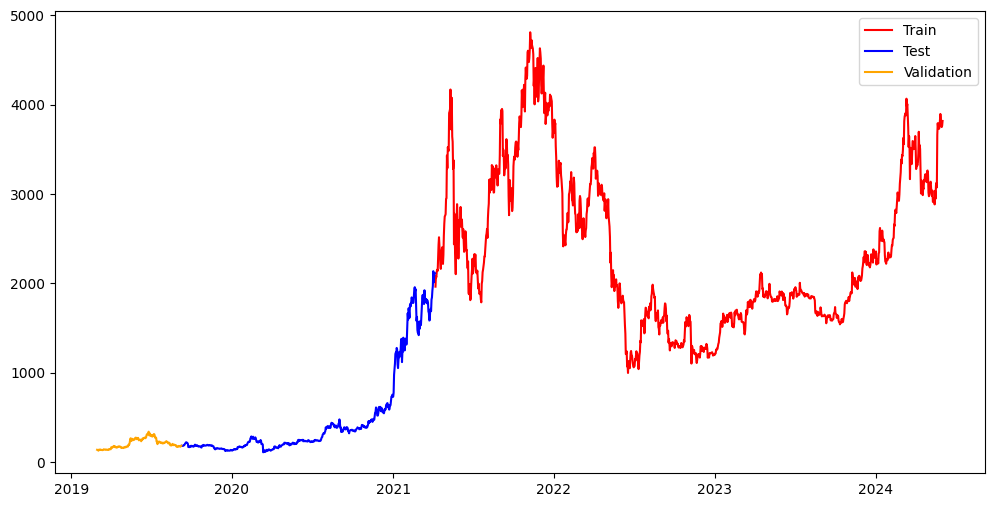

In [139]:
plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(eth_df_train).index.to_list(), pd.DataFrame(eth_df_train['Price']), color='red', label='Train')
plt.plot(pd.DataFrame(eth_df_test).index.to_list(),pd.DataFrame(eth_df_test['Price']),color='blue' ,label ='Test')
plt.plot(pd.DataFrame(eth_df_val).index.to_list(),pd.DataFrame(eth_df_val['Price']),color ='orange', label ='Validation')
plt.legend()
plt.show()

In [140]:
scaler = MinMaxScaler(feature_range=(0, 1))
eth_df_train_scaled = scaler.fit_transform(eth_df_train)
eth_df_test_scaled = scaler.transform(eth_df_test)
eth_df_val_scaled = scaler.transform(eth_df_val)

eth_df_train_scaled = pd.DataFrame(eth_df_train_scaled, index=eth_df_train.index, columns=eth_df_train.columns)
eth_df_test_scaled = pd.DataFrame(eth_df_test_scaled, index=eth_df_test.index, columns=eth_df_test.columns)
eth_df_val_scaled = pd.DataFrame(eth_df_val_scaled,index =eth_df_val.index,columns=eth_df_val.columns)

In [141]:
X_train_scale = eth_df_train_scaled.drop(columns=['Price'])
y_train_scale = eth_df_train_scaled['Price']

X_test_scale  = eth_df_test_scaled.drop(columns=['Price'])
y_test_scale  = eth_df_test_scaled['Price']

X_val_scale = eth_df_val_scaled.drop(columns=['Price'])
y_val_scale = eth_df_val_scaled['Price']

In [142]:
print('X_train_scale shape: ',X_train_scale.shape)
print('y_train_scale shape: ',y_train_scale.shape)
print('\nX_test_scale shape: ',X_test_scale.shape)
print('y_test_scale shape: ',y_test_scale.shape)
print('\nX_val_scale shape: ',X_val_scale.shape)
print('y_val_scale shape: ',y_val_scale.shape)

X_train_scale shape:  (1152, 8)
y_train_scale shape:  (1152,)

X_test_scale shape:  (576, 8)
y_test_scale shape:  (576,)

X_val_scale shape:  (192, 8)
y_val_scale shape:  (192,)


#RNN

In [143]:
df1=eth_df.reset_index()['Price']

In [144]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [156]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

Train shape: (1152, 1)
Test shape: (576, 1)
Validate shape: (192, 1)


In [145]:
# 5. Hàm Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [146]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [147]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [148]:
# 8. Define RNN Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [149]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, ytest), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
20/20 [==============================] - 2s 37ms/step - loss: 0.0154 - val_loss: 3.6600e-04
Epoch 2/100
20/20 [==============================] - 0s 23ms/step - loss: 0.0020 - val_loss: 1.5188e-04
Epoch 3/100
20/20 [==============================] - 0s 24ms/step - loss: 0.0011 - val_loss: 3.7951e-05
Epoch 4/100
20/20 [==============================] - 0s 24ms/step - loss: 8.3151e-04 - val_loss: 2.5828e-05
Epoch 5/100
20/20 [==============================] - 1s 43ms/step - loss: 7.7090e-04 - val_loss: 4.2428e-05
Epoch 6/100
20/20 [==============================] - 1s 44ms/step - loss: 7.2470e-04 - val_loss: 2.8473e-05
Epoch 7/100
20/20 [==============================] - 1s 41ms/step - loss: 6.9951e-04 - val_loss: 3.0485e-05
Epoch 8/100
20/20 [==============================] - 1s 44ms/step - loss: 6.8433e-04 - val_loss: 4.2595e-05
Epoch 9/100
20/20 [==============================] - 1s 40ms/step - loss: 6.9831e-04 - val_loss: 2.0320e-05
Epoch 10/100
20/20 [====================

In [150]:
# 10. Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

15/15 [==============================] - 0s 7ms/step


In [151]:
# 11. Chuẩn hóa dữ liệu y_pred
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)

In [152]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - scaler.inverse_transform(ytest.reshape(-1, 1)))**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 20.62297684519943


In [153]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

TypeError: 'float' object cannot be interpreted as an integer

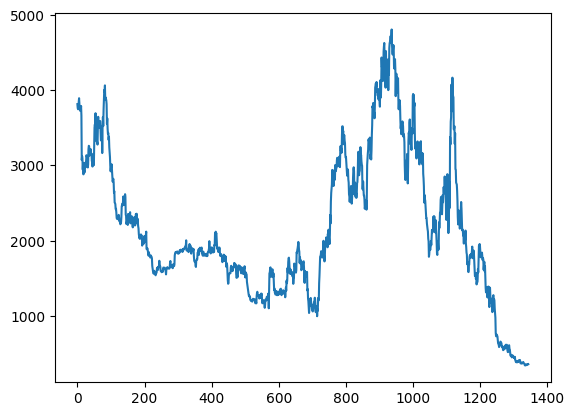

In [154]:
# 14. Vẽ hình
plt.plot(scaler.inverse_transform(train_data), label='Train Data')
plt.plot(range(train_size, train_size + len(test_data)), scaler.inverse_transform(test_data), label='Test Data')
plt.plot(range(train_size + 100, train_size + 100 + len(y_pred)), y_pred, label='Predicted Test Data')
plt.plot(range(len(df1), len(df1) + 30), scaler.inverse_transform(lst_output), label='Predicted Next 30 Days')

plt.legend()
plt.show()

In [ ]:
# 13. Dự báo 60 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while i < 60:  # Sửa số lần lặp từ 30 thành 60
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

# 14. Vẽ hình
plt.plot(scaler.inverse_transform(train_data), label='Train Data')
plt.plot(range(train_size, train_size + len(test_data)), scaler.inverse_transform(test_data), label='Test Data')
plt.plot(range(train_size + 100, train_size + 100 + len(y_pred)), y_pred, label='Predicted Test Data')
plt.plot(range(len(df1), len(df1) + 60), scaler.inverse_transform(lst_output), label='Predicted Next 60 Days')  # Sửa số ngày từ 30 thành 60

plt.legend()
plt.show()

In [ ]:
# 13. Dự báo 90 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while i < 90:  # Sửa số lần lặp từ 30 thành 90
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

# 14. Vẽ hình
plt.plot(scaler.inverse_transform(train_data), label='Train Data')
plt.plot(range(train_size, train_size + len(test_data)), scaler.inverse_transform(test_data), label='Test Data')
plt.plot(range(train_size + 100, train_size + 100 + len(y_pred)), y_pred, label='Predicted Test Data')
plt.plot(range(len(df1), len(df1) + 90), scaler.inverse_transform(lst_output), label='Predicted Next 90 Days')  # Sửa số ngày từ 30 thành 90

plt.legend()
plt.show()

###LSTM

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

In [ ]:
# 5. Hàm Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# 8. Define LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [82]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
20/20 [==============================] - 12s 259ms/step - loss: 0.0262 - val_loss: 0.0124
Epoch 2/100
20/20 [==============================] - 4s 200ms/step - loss: 0.0062 - val_loss: 0.0021
Epoch 3/100
20/20 [==============================] - 5s 265ms/step - loss: 0.0037 - val_loss: 6.6150e-05
Epoch 4/100
20/20 [==============================] - 4s 182ms/step - loss: 0.0036 - val_loss: 5.6375e-04
Epoch 5/100
20/20 [==============================] - 4s 182ms/step - loss: 0.0032 - val_loss: 2.2909e-04
Epoch 6/100
20/20 [==============================] - 6s 297ms/step - loss: 0.0029 - val_loss: 2.8708e-04
Epoch 7/100
20/20 [==============================] - 5s 231ms/step - loss: 0.0028 - val_loss: 2.3666e-04
Epoch 8/100
20/20 [==============================] - 7s 379ms/step - loss: 0.0025 - val_loss: 1.6538e-04
Epoch 9/100
20/20 [==============================] - 8s 397ms/step - loss: 0.0023 - val_loss: 8.7229e-05
Epoch 10/100
20/20 [==============================] - 11s 541m

In [83]:
# 10. Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

15/15 [==============================] - 1s 47ms/step


In [84]:
# 11. Chuẩn hóa dữ liệu y_pred
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)

In [85]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - scaler.inverse_transform(y_test.reshape(-1, 1)))**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 0.0029906828755177626


In [86]:
# 13. Dự báo 30 ngày tiếp theo
n_steps = 100
x_input = test_data[-n_steps:].reshape(1, -1)
x_input.shape

temp_input = list(x_input[0])

from numpy import array

lst_output = []
i = 0
while(i < 30):
    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

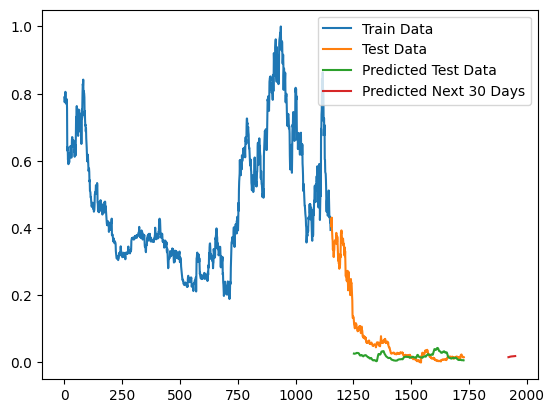

In [87]:
# 14. Vẽ hình
plt.plot(scaler.inverse_transform(train_data), label='Train Data')
plt.plot(range(train_size, train_size + len(test_data)), scaler.inverse_transform(test_data), label='Test Data')
plt.plot(range(train_size + time_step, train_size + time_step + len(y_pred)), y_pred, label='Predicted Test Data')
plt.plot(range(len(df1), len(df1) + 30), scaler.inverse_transform(lst_output), label='Predicted Next 30 Days')

plt.legend()
plt.show()

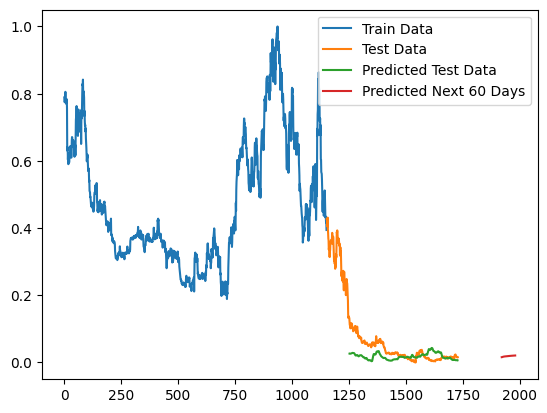

In [88]:
# 13. Dự báo 60 ngày tiếp theo
n_steps = 100
x_input = test_data[-n_steps:].reshape(1, -1)
x_input.shape

temp_input = list(x_input[0])

from numpy import array

lst_output = []
i = 0
while(i < 60):  # Đổi từ 30 thành 60
    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

# 14. Vẽ hình
plt.plot(scaler.inverse_transform(train_data), label='Train Data')
plt.plot(range(train_size, train_size + len(test_data)), scaler.inverse_transform(test_data), label='Test Data')
plt.plot(range(train_size + time_step, train_size + time_step + len(y_pred)), y_pred, label='Predicted Test Data')
plt.plot(range(len(df1), len(df1) + 60), scaler.inverse_transform(lst_output), label='Predicted Next 60 Days')

plt.legend()
plt.show()


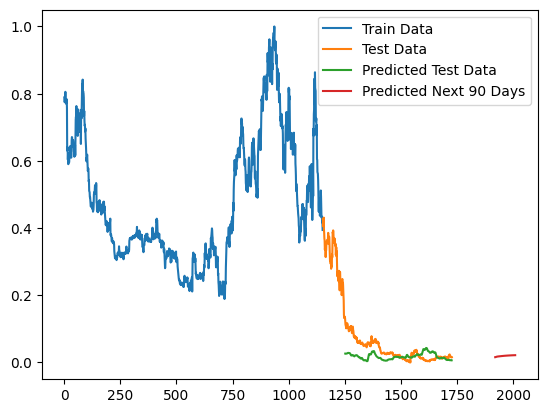

In [89]:
# 13. Dự báo 90 ngày tiếp theo
n_steps = 100
x_input = test_data[-n_steps:].reshape(1, -1)
x_input.shape

temp_input = list(x_input[0])

from numpy import array

lst_output = []
i = 0
while(i < 90):  # Đổi từ 60 thành 90
    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

# 14. Vẽ hình
plt.plot(scaler.inverse_transform(train_data), label='Train Data')
plt.plot(range(train_size, train_size + len(test_data)), scaler.inverse_transform(test_data), label='Test Data')
plt.plot(range(train_size + time_step, train_size + time_step + len(y_pred)), y_pred, label='Predicted Test Data')
plt.plot(range(len(df1), len(df1) + 90), scaler.inverse_transform(lst_output), label='Predicted Next 90 Days')

plt.legend()
plt.show()

## Linear regression

In [ ]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from scipy import stats

In [ ]:
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [ ]:
X_train_lr = X_train_scale
y_train_lr = y_train_scale

X_test_lr  = X_test_scale
y_test_lr = y_test_scale

X_val_lr = X_val_scale
y_val_lr = y_val_scale

In [ ]:
model_LR = LinearRegression()
model_LR.fit(X_train_scale, y_train_scale)

In [ ]:
pred_test_LR = model_LR.predict(X_test_scale)
pred_val_LR = model_LR.predict(X_val_lr)

In [ ]:
mape = mean_absolute_percentage_error(y_test_scale, pred_test_LR)
mae = mean_absolute_error(y_test_scale,pred_test_LR)
mse = mean_squared_error(y_test_scale, pred_test_LR)
print(f'Mean Absolute Percentage Error: {mape}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {math.sqrt(mse)}')

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(pd.DataFrame(y_train_scale).index.to_list(),pd.DataFrame(y_train_lr),color='red',label='Train value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(y_test_lr), color='blue', label='Test value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(pred_test_LR.reshape(-1)), color='green', label='Predicted test value')
plt.plot(pd.DataFrame(y_val_scale).index.to_list(),pd.DataFrame(y_val_lr),color='orange', label='Validation value')
plt.plot(pd.DataFrame(y_val_scale).index.to_list(),pd.DataFrame(pred_val_LR.reshape(-1)),color='purple', label='Predicted validation value')
plt.legend()
plt.show()

In [ ]:
model_filename = "model_LR.joblib"
joblib.dump(model_LR, model_filename)

In [ ]:
y

In [ ]:
X_test =X_test.sort_index(ascending=True)
X_test

In [ ]:
X_train

In [ ]:
test_data =X_test.join(y_test)
test_data =test_data.sort_index(ascending=True)
test_data

###ARIMA

###Draft

In [ ]:
# Format "Date" column
eth_df['Date'] = pd.to_datetime(eth_df['Date'], format='%m/%d/%Y')

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(eth_df['Date'], bins=20, kde=True)
plt.title('Histogram of Ethereum Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [ ]:
new_df=eth_df.drop[['Price', 'Change %']]
X =new_df.drop(['Price'],axis = 1)
y = new_df['Change %']

In [ ]:
print('x_scale.shape: ',x_scale.shape)
print('y_scale.shape: ',y_scale.shape)

In [ ]:
x_train, y_train, x_test, y_test = train_test_split(x_scale, y_scale, 0.2, 10)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ',y_train.shape)
print('X_test.shape: ',X_test.shape)
print('y_test.shape: ',y_test.shape)